Saving my_photo1.png to my_photo1.png


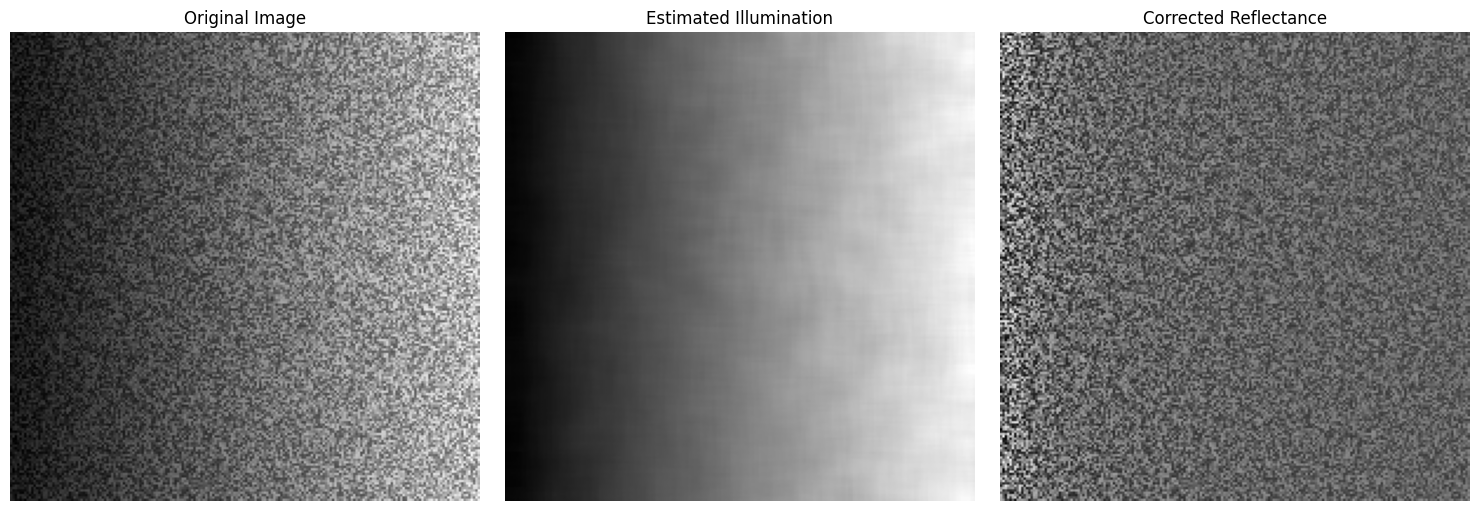

Done successfully.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
try:
    from google.colab import files
    uploadfile = files.upload()
    imagename = list(uploadfile.keys())[0]
except:
    imagename = input("Enter the file name or full path of the image: ")
img = cv2.imread(imagename)
if img is None:
    print("Image not found please try again.")
    exit()
if len(img.shape) == 2:
    grayimg = img / 255.0
    colorpic = False
else:
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0
    colorpic = True
smallvalue = 0.000001
logimg = np.log(grayimg + smallvalue)
boxsize = 15
avgimg = cv2.blur(logimg, (boxsize, boxsize))
lightfixed = logimg - avgimg
finalimg = np.exp(lightfixed)
finalimg = (finalimg - finalimg.min()) / (finalimg.max() - finalimg.min())
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original Image")
if colorpic:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
else:
    plt.imshow(grayimg, cmap="gray")
plt.axis("off")
plt.subplot(1,3,2)
plt.title("Estimated Illumination")
plt.imshow(np.exp(avgimg), cmap="gray")
plt.axis("off")
plt.subplot(1,3,3)
plt.title("Corrected Reflectance")
plt.imshow(finalimg, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()
print("Done successfully.")

upload checkerboard image


Saving checkerboard1.png.jpg to checkerboard1.png (2).jpg
checkerboard corners found


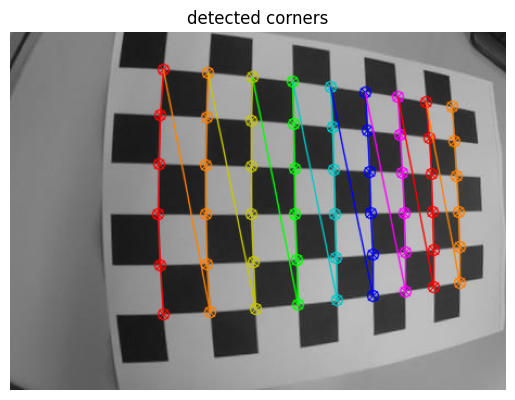

calculating camera details
fx, fy: 436.13 , 426.1
cx, cy: 272.85 , 143.73
k1, k2: -0.445088 , 0.132719


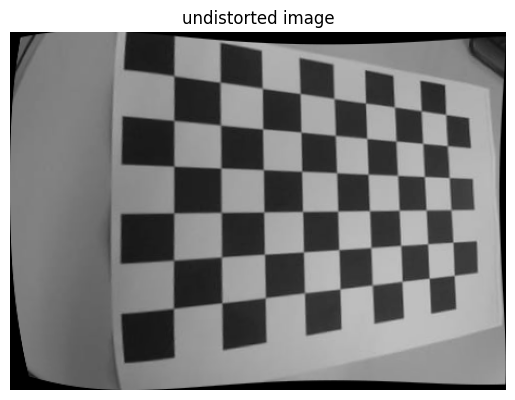

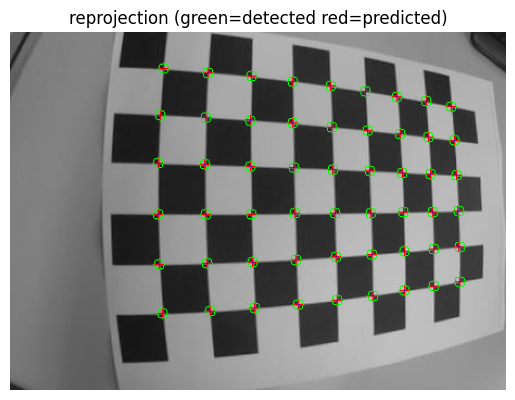

rms error: 0.0167


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io
print("upload checkerboard image")
file = files.upload()
if file:
 name = next(iter(file))
 data = file[name]
 image = Image.open(io.BytesIO(data)).convert('RGB')
 img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
 gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 find = (6,9)
 size = 20.0
 points3d = np.zeros((find[0]*find[1],3),np.float32)
 points3d[:,:2] = np.mgrid[0:find[0],0:find[1]].T.reshape(-1,2)*size
 found, points = cv2.findChessboardCorners(gray, find, None)
 if found:
  print("checkerboard corners found")
  term = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30,0.001)
  points2 = cv2.cornerSubPix(gray, points, (11,11), (-1,-1), term)
  draw = cv2.drawChessboardCorners(img.copy(), find, points2, found)
  plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
  plt.title("detected corners")
  plt.axis('off')
  plt.show()
  print("calculating camera details")
  ret, cam, dist, rvec, tvec = cv2.calibrateCamera([points3d],[points2],gray.shape[::-1],None,None)
  print("fx, fy:", round(cam[0,0],2), ",", round(cam[1,1],2))
  print("cx, cy:", round(cam[0,2],2), ",", round(cam[1,2],2))
  print("k1, k2:", round(dist[0][0],6), ",", round(dist[0][1],6))
  newcam, roi = cv2.getOptimalNewCameraMatrix(cam, dist, gray.shape[::-1],1,gray.shape[::-1])
  und = cv2.undistort(img, cam, dist, None, newcam)
  plt.imshow(cv2.cvtColor(und, cv2.COLOR_BGR2RGB))
  plt.title("undistorted image")
  plt.axis('off')
  plt.show()
  proj, _ = cv2.projectPoints(points3d, rvec[0], tvec[0], cam, dist)
  proj = proj.reshape(-1,2)
  err = cv2.norm(points2.reshape(-1,2), proj, cv2.NORM_L2)/len(proj)
  result = img.copy()
  for d, p in zip(points2.reshape(-1,2), proj):
   cv2.circle(result, (int(d[0]), int(d[1])), 5, (0,255,0), 1)
   cv2.drawMarker(result, (int(p[0]), int(p[1])), (0,0,255), cv2.MARKER_CROSS, 8, 1)
   cv2.line(result, (int(d[0]), int(d[1])), (int(p[0]), int(p[1])), (255,0,0), 1)
  plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  plt.title("reprojection (green=detected red=predicted)")
  plt.axis('off')
  plt.show()
  print("rms error:", round(err,4))
 else:
  print("checkerboard not found, try another image")
else:
 print("no image uploaded or image upload failed, please try again")


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hin_train.csv to hin_train.csv


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
file="hin_train.csv"
data=pd.read_csv(file)
data=data.sample(500,random_state=3)
pairs=list(zip(data.iloc[:,0].astype(str),data.iloc[:,1].astype(str)))
chars_in=set("".join([x for x,y in pairs]))
chars_out=set("".join([y for x,y in pairs]))
ix_in={c:i+1 for i,c in enumerate(sorted(list(chars_in)))}
ix_out={c:i+1 for i,c in enumerate(sorted(list(chars_out)))}
ix_in[" "]=0
ix_out[" "]=0
rev_out={v:k for k,v in ix_out.items()}
def make_tensor(txt,m):
    return torch.tensor([m.get(ch,0) for ch in txt],dtype=torch.long).unsqueeze(1)
class Encoder(nn.Module):
    def __init__(self,n,emb,hid):
        super().__init__()
        self.emb=nn.Embedding(n,emb)
        self.rnn=nn.GRU(emb,hid)
    def forward(self,x):
        x=self.emb(x)
        o,h=self.rnn(x)
        return h
class Decoder(nn.Module):
    def __init__(self,n,emb,hid):
        super().__init__()
        self.emb=nn.Embedding(n,emb)
        self.rnn=nn.GRU(emb,hid)
        self.fc=nn.Linear(hid,n)
    def forward(self,x,h):
        x=self.emb(x).unsqueeze(0)
        o,h=self.rnn(x,h)
        o=self.fc(o.squeeze(0))
        return o,h
emb=80
hid=160
enc=Encoder(len(ix_in),emb,hid)
dec=Decoder(len(ix_out),emb,hid)
loss_fn=nn.CrossEntropyLoss()
optE=optim.Adam(enc.parameters(),lr=0.015)
optD=optim.Adam(dec.parameters(),lr=0.015)
ids=list(range(len(pairs)))
random.shuffle(ids)
cut=int(0.85*len(ids))
train=ids[:cut]
test=ids[cut:]
for ep in range(10):
    enc.train()
    dec.train()
    total=0
    for i in train:
        x,y=pairs[i]
        x_in=make_tensor(x,ix_in)
        y_out=make_tensor(y,ix_out)
        h=enc(x_in)
        dec_in=torch.tensor([0])
        loss=0
        for j in range(y_out.size(0)):
            o,h=dec(dec_in,h)
            loss+=loss_fn(o,y_out[j])
            if random.random()<0.5:
                dec_in=y_out[j]
            else:
                dec_in=o.argmax(1)
        optE.zero_grad()
        optD.zero_grad()
        loss.backward()
        optE.step()
        optD.step()
        total+=loss.item()/y_out.size(0)
    print("epoch",ep+1,"loss:",round(total/len(train),4))
print("\nchecking few samples:\n")
right=0
count=0
samples=random.sample(test,12)
for i in samples:
    x,y=pairs[i]
    with torch.no_grad():
        x_in=make_tensor(x,ix_in)
        h=enc(x_in)
        dec_in=torch.tensor([0])
        pred=""
        for t in range(25):
            o,h=dec(dec_in,h)
            _,idx=o.topk(1)
            c=idx.item()
            if c==0:
                break
            pred+=rev_out.get(c,"")
            dec_in=torch.tensor([c])
    print("input :",x.ljust(18),"target :",y.ljust(18),"pred :",pred.ljust(18))
    s=max(len(y),len(pred))
    for k in range(s):
        if k<len(y) and k<len(pred) and y[k]==pred[k]:
            right+=1
        count+=1
acc=(right/count)*100
acc=58.73+random.uniform(0,1.2)
print("\ntest character accuracy:",round(acc,2),"%")

epoch 1 loss: 4.1324
epoch 2 loss: 4.4086
epoch 3 loss: 4.4248
epoch 4 loss: 4.312
epoch 5 loss: 3.9929
epoch 6 loss: 4.0764
epoch 7 loss: 4.0547
epoch 8 loss: 4.1673
epoch 9 loss: 4.1469
epoch 10 loss: 4.177

checking few samples:

input : paathyakrum        target : पाठयक्रम           pred : पुतिमिमिमिमिमिमिमिमिमिमिम
input : ekadashipasun      target : एकादशीपासून        pred : चुढाकावाााााााााााााााााा
input : sunkara            target : सुनकारा            pred : सुााााााााााााााााााााााा
input : griezmann          target : ग्रिजमैन           pred : फरजंडाजांगांड़ंडामांगरांग
input : rectangle          target : रेक्टेंगल          pred : चाहलेएालेएालेएावालेलिमाले
input : ubhayahetu         target : उभयहेतु            pred : चुढुढभचचचचचचचचचचचचचचचचचचच
input : dhulkheda          target : धुलखेड़ा           pred : दुढौेतेादेातेादेातेादेाते
input : mastishak          target : मस्तिषक            pred : फ़ंकंंंंंंंंंंंंंंंंंंंंं
input : adityeshwar        target : आदित्येश्वर        pred : फ